In [1]:
# Project Template Import Cell
%matplotlib inline
import os
import sys
import math

from __future__ import print_function, division
from inspect import getsourcefile

from IPython.display import FileLink

# Standard Notebook Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.width', 120)

CURR_PATH = os.path.abspath(getsourcefile(lambda:0)).rsplit('/', 1)[0] # Get filepath of this notebook
module_path = os.path.join(os.path.dirname(CURR_PATH), 'utils') # Make module path for one dir up and one down into utils
if module_path not in sys.path: # Append to system path list
    sys.path.append(module_path)

import utils as utils ; reload(utils)

print('System : Python ', os.sys.version , '\n\n')

print('Directory Structure:')
print(CURR_PATH)
!tree -cn --filelimit 20

# Keras Setup
import keras
print('\n\nKeras version:' , keras.__version__ ,
      ', backend:' , keras.backend.backend(),
      ', image_format:' , keras.backend.image_data_format())

random_seed = 7

print('\n\nEnvironment : ')
FileLink('../../ana_py27_p2.yml')
#print(sys.path)

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


System : Python  2.7.12 | packaged by conda-forge | (default, Sep  8 2016, 14:22:31) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)] 


Directory Structure:
/home/ubuntu/ana_py27_p2/projects/CervicalCancer
.
├── unused_utils
│   ├── __init__.py
│   ├── __init__.pyc
│   ├── utils.pyc
│   └── unused_utils.py
├── __init__.py
├── 003 - Baseline.ipynb
├── 002 - Sample Setup.ipynb
├── 001 - Initial Setup.ipynb
├── data
│   ├── additional_Type_1_v2.7z
│   ├── additional_Type_3_v2.7z
│   ├── additional_Type_2_v2.7z
│   ├── train
│   │   ├── Type_1 [168 entries exceeds filelimit, not opening dir]
│   │   ├── Type_2 [524 entries exceeds filelimit, not opening dir]
│   │   └── Type_3 [302 entries exceeds filelimit, not opening dir]
│   ├── test
│   │   └── unknown [512 entries exceeds filelimit, not opening dir]
│   ├── preview
│   ├── downloads
│   │   ├── sample_submission.csv.zip
│   │   ├── test.7z
│   │   └── train.7z
│   ├── valid
│   │   ├── Type_1 [82 entries exceeds filelimit, not opening dir]


/home/ubuntu/ana_py27_p2/ana_py27_p2.yml

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [3]:
# A fix for truncated image error
# http://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
img_width, img_height = 150, 150

In [5]:
# SAMPLE
#train_data_dir = 'data/sample/train'
#validation_data_dir = 'data/sample/valid'
#test_data_dir = 'data/sample/test'
#weights_dir = 'data/sample/weights'

# TRAIN DATA
train_data_dir = 'data/train'
validation_data_dir = 'data/valid'
test_data_dir = 'data/test'
weights_dir = 'data/weights'

submission_dir = 'data/submissions'

num_training_samples = 0
for class_dir in utils.get_non_hidden_dir_contents(train_data_dir):
    num_training_samples += len(utils.get_non_hidden_dir_contents(class_dir))
num_validation_samples = 0
for class_dir in utils.get_non_hidden_dir_contents(validation_data_dir):
    num_validation_samples += len(utils.get_non_hidden_dir_contents(class_dir))    

print(num_training_samples)
print(num_validation_samples)

994
487


In [6]:
input_shape = (img_width, img_height, 3)
epochs = 40
batch_size=64
train_steps = int(math.ceil(num_training_samples / batch_size))
validation_steps =  int(math.ceil(num_validation_samples / batch_size))
print(train_steps)
print(validation_steps)

16
8


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

In [8]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
            metrics=['accuracy'])

In [10]:
# checkpoint
# http://machinelearningmastery.com/check-point-deep-learning-models-keras/
filen="weights1-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath = os.path.join(weights_dir, filen)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#callbacks_list=None

In [11]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    classes = ['Type_1', 'Type_2', 'Type_3'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    classes = ['Type_1', 'Type_2', 'Type_3'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 994 images belonging to 3 classes.
Found 487 images belonging to 3 classes.


In [13]:
# Use this for preliminary timing on the AWS p2 instance, so can estimate a good size for the sample directory files
import time
start_time = time.time()

In [14]:
# Based on number of training images per Type in train_dir
class_weight_dict = utils.get_class_weight_dict([168, 524, 302])
print(class_weight_dict)

{0: 3.119047619047619, 1: 1.0, 2: 1.7350993377483444}


In [15]:
h = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight = class_weight_dict,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/40
16/16 [==============================] - 321s - loss: 1.7343 - acc: 0.3256 - val_loss: 1.0990 - val_acc: 0.2875
Epoch 2/40
16/16 [==============================] - 205s - loss: 1.7350 - acc: 0.3217 - val_loss: 1.1000 - val_acc: 0.2690
Epoch 3/40
16/16 [==============================] - 207s - loss: 1.7228 - acc: 0.3398 - val_loss: 1.1011 - val_acc: 0.2669
Epoch 4/40
16/16 [==============================] - 204s - loss: 1.7261 - acc: 0.3350 - val_loss: 1.0959 - val_acc: 0.2895
Epoch 5/40
16/16 [==============================] - 215s - loss: 1.7223 - acc: 0.3401 - val_loss: 1.0921 - val_acc: 0.3039
Epoch 6/40
16/16 [==============================] - 205s - loss: 1.7108 - acc: 0.4240 - val_loss: 1.0670 - val_acc: 0.4476
Epoch 7/40
16/16 [==============================] - 204s - loss: 1.6976 - acc: 0.4173 - val_loss: 1.0966 - val_acc: 0.2813
Epoch 8/40
16/16 [==============================] - 202s - loss: 1.6867 - acc: 0.3882 - val_loss: 1.0867 - val_acc: 0.2957
Epoch 9/40
16/16

In [16]:
# Use this for preliminary timing on the AWS p2 instance, so can estimate a good size for the sample directory files
print("%f seconds" % (time.time() - start_time))
print('Total Images Processed ' , str(num_training_samples + num_validation_samples))
print('Epochs :', str(h.epoch[-1]+ 1))

8407.520051 seconds
Total Images Processed  1481
Epochs : 40


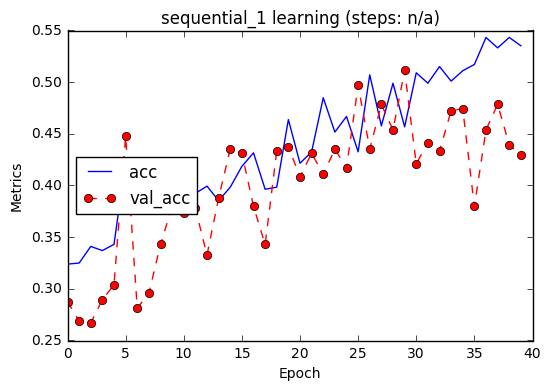

In [18]:
utils.plot_learning(h)

In [30]:
fns = utils.get_non_hidden_dir_contents(os.path.join(test_data_dir, 'unknown'))
#test_batch_size = len(fns)
pred_batch_size= 57
pred_steps=9 # 57 x 9 = 513  #11 x 19 = 209 vs filenames/preds of 201
print(test_batch_size)
pred_gen = ImageDataGenerator(rescale=1. / 255,)
pred_generator = pred_gen.flow_from_directory(
    test_data_dir,
    shuffle=False,
    classes = ['unknown'],
    target_size=(img_width, img_height),
    batch_size=test_batch_size,
    color_mode='rgb',
    class_mode='categorical')

57
Found 512 images belonging to 1 classes.


In [32]:
preds = model.predict_generator(pred_generator, steps = pred_steps)
filenames = pred_generator.filenames

In [33]:
print(preds.shape)
print(filenames[0:10])
print(preds[0:5,:])
df = pd.DataFrame(preds)
print(df.head())
print(len(filenames))

(512, 3)
['unknown/400.jpg', 'unknown/430.jpg', 'unknown/303.jpg', 'unknown/126.jpg', 'unknown/487.jpg', 'unknown/18.jpg', 'unknown/248.jpg', 'unknown/502.jpg', 'unknown/383.jpg', 'unknown/478.jpg']
[[ 0.234   0.3516  0.4144]
 [ 0.1961  0.3567  0.4472]
 [ 0.6045  0.2352  0.1602]
 [ 0.31    0.3206  0.3695]
 [ 0.2071  0.3772  0.4157]]
          0         1         2
0  0.234011  0.351562  0.414427
1  0.196094  0.356667  0.447239
2  0.604534  0.235235  0.160231
3  0.309962  0.320580  0.369458
4  0.207090  0.377212  0.415698
512


In [41]:
# SAMPLE
#df = pd.DataFrame(preds)
#df['File_Name'] = [fn.split('/')[1] for fn in filenames]
#df['True_Type'] = [int(fn.split('/')[1].split('_')[0]) for fn in filenames]
#print(df.columns)
#df.columns = [1,2,3,'File_Name','True_Type']
#df['Pred_Type'] = df[[1,2,3]].idxmax(axis=1, skipna=True)
#df.columns = [1 , 2, 3, 'File_Name',  'True_Type', 'Pred_Type']
#print(df.head(25))

# Form the submission file DataFrame - Now moved into utils.
df = pd.DataFrame(preds)
df['image_name'] = [fn.split('/')[1] for fn in filenames]
print(df.columns)
df.columns = ['Type_1', 'Type_2', 'Type_3','image_name']
#df['Pred_Type'] = df[[1,2,3]].idxmax(axis=1, skipna=True)
#df.columns = [1 , 2, 3, 'File_Name',  'True_Type', 'Pred_Type']
df = df[['image_name', 'Type_1', 'Type_2','Type_3']]
df['temp_sort_col'] = df['image_name'].apply(lambda x: int(x.split('.')[0]))
df = df.sort_values(by=['temp_sort_col'], ascending=True)
df = df.drop('temp_sort_col', axis=1)
print(df.head(25))


Index([0, 1, 2, u'image_name'], dtype='object')
    image_name    Type_1    Type_2    Type_3
155      0.jpg  0.201520  0.371375  0.427105
291      1.jpg  0.156162  0.360510  0.483329
170      2.jpg  0.413870  0.375796  0.210334
146      3.jpg  0.135489  0.312937  0.551574
237      4.jpg  0.035460  0.183454  0.781086
115      5.jpg  0.499809  0.399632  0.100559
161      6.jpg  0.642955  0.297561  0.059484
389      7.jpg  0.136384  0.325447  0.538169
342      8.jpg  0.129631  0.321143  0.549226
378      9.jpg  0.425292  0.306031  0.268677
257     10.jpg  0.671341  0.235167  0.093492
101     11.jpg  0.091911  0.272508  0.635581
299     12.jpg  0.115097  0.255438  0.629465
491     13.jpg  0.137895  0.282236  0.579869
88      14.jpg  0.053551  0.235312  0.711137
410     15.jpg  0.245870  0.223667  0.530464
224     16.jpg  0.185708  0.336213  0.478080
59      17.jpg  0.465917  0.372054  0.162029
5       18.jpg  0.612555  0.259963  0.127483
500     19.jpg  0.074166  0.249114  0.676719
361    

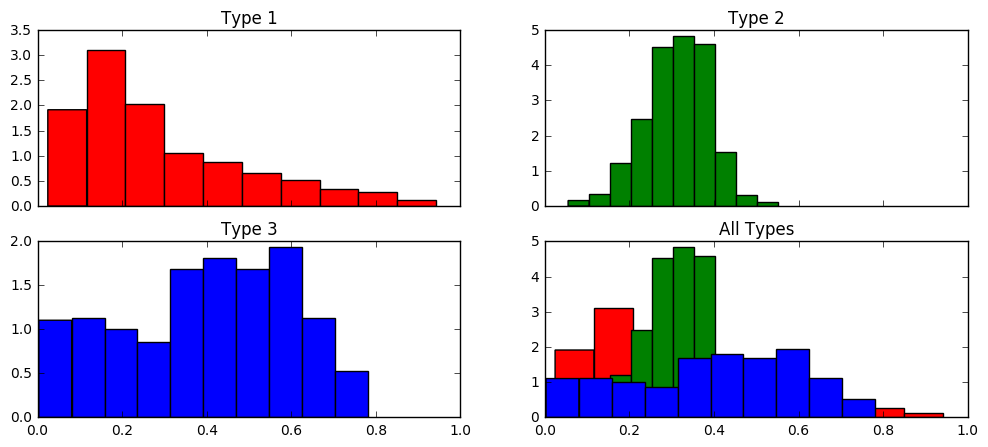

In [42]:
utils.plot_response_distribution_known_class(df['Type_1'].values, df['Type_2'].values, df['Type_3'].values)    

In [43]:
df = utils.form_submission_df(preds, filenames)
utils.save_submission_csv(submission_dir,df)

('Saved to ', 'data/submissions/sub_003.csv')


In [ ]:
print(sub.head(25))

In [44]:
model.save_weights(os.path.join(weights_dir, 'BaseCNN40EpochRun_1.hdf5'))

### Load Best Weights, Make Prediction on Test Set, Save & Submit

Best weights occurred at Epoch 30

Epoch 30/40

15/16 [===========================>..] - ETA: 5s - loss: 1.5240 - acc: 0.4552

Epoch 00029: val_acc improved from 0.49692 to 0.51129, saving model to data/weights/weights1-improvement-29-0.51.hdf5

In [45]:
model.load_weights('data/weights/weights1-improvement-29-0.51.hdf5')

In [46]:
fns = utils.get_non_hidden_dir_contents(os.path.join(test_data_dir, 'unknown'))
#test_batch_size = len(fns)
pred_batch_size= 57
pred_steps=9 # 57 x 9 = 513  #11 x 19 = 209 vs filenames/preds of 201
print(test_batch_size)
pred_gen = ImageDataGenerator(rescale=1. / 255,)
pred_generator = pred_gen.flow_from_directory(
    test_data_dir,
    shuffle=False,
    classes = ['unknown'],
    target_size=(img_width, img_height),
    batch_size=test_batch_size,
    color_mode='rgb',
    class_mode='categorical')

57
Found 512 images belonging to 1 classes.


In [47]:
preds = model.predict_generator(pred_generator, steps = pred_steps)
filenames = pred_generator.filenames

In [48]:
sub_df = utils.form_submission_df(preds, filenames)

In [49]:
utils.save_submission_csv(submission_dir,sub_df)

('Saved to ', 'data/submissions/sub_004.csv')


### Notes
1. The model was learning quite well up until Epoch 30, when the training, and validation accuracy seemed to part ways. It looks like the model started overfitting. I could look at reducing this on this model, but I think I will get a better model loaded (hopefully with some pre-training) and spend time on that.
2. Based on a review of the images, it seems that there is a fair amount of "noise" in the images. I suspect that reducing this noise ie. doing some basic image segmentation will help the model learn. This is my next step

### Kaggle Results

The results are improving sub_004 put me at 267 out of 540 entries with 1 month to go. This is within the top 50% (only just) as per my objective

sub_004.csv
24 minutes ago by DavMacG
Basic CNN Train Data Only Best Weights
0.96563

sub_003.csv
36 minutes ago by DavMacG
Basic CNN Train Data Only
0.99110

sub_002.csv
23 days ago by DavMacG
002
1.09861

sub_001.csv
23 days ago by DavMacG
001
1.00575
